## Genetski algoritam

Zadatak: Genetskim algoritmom odrediti jednakokraki trougao maksimalne povrsine, upisan u elipsu:

$$ \frac{x^2}{a^2} + \frac{y^2}{b^2} = 1$$
 
Resenje: Dve tacke trougla definisemo, redom, uglovima $\alpha$, $\beta$ koji su u opsegu $[0, 2 \pi)$.

Za dati ugao $\theta$, tacka ce pripadati elipsi ako je

$$ x = a \cos \theta, \quad y = b \sin \theta$$

Treca tacka je definisana time sto trougao treba da bude jednakokraki. 
Ako su poznate koordinate prve dve tacke, tada koordinate trece tacke zadovoljavaju jednacine:

$$ x (x_1 - x_2) + y (y_1 - y_2) = \frac{x_1^2 + y_1^2}{2} + \frac{x_2^2 + y_2^2}{2}$$

$$ x^2 b^2 + y^2a^2 = a^2 b^2$$
 
Uglove cemo da definisemo koriscenjem 12 bita. Prema tome duzina jednog hromozoma je L=24 .

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.stats import rankdata

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Definicija osnovnih parametara algoritma.

N = 50 # broj jedinki u populaciji
L = 36 # duzina hromozoma
pc = 0.9 # verovatnoca ukrstanja
pm = 0.001 # vertovatnoca mutacije
G = 0.8 # procenat populacije koji se menja u narednoj generaciji

## Parametri elipse
a = 15
b = 3
a2 = 15 ** 2
b2 = 3 ** 2

In [3]:
# Funkcija koja iscrtava elipsu na prosledjenoj figuri.
def plot_elipse(fig, a, b):
    
    theta = np.linspace(0, 2*pi, 200)
    x = a * np.cos(theta)
    y = b * np.sin(theta)
    
    plt.figure(fig)
    plt.plot(x, y)

In [4]:
# Funkcija koja iscrtava trouglove na prosledjenoj figuri.
def plot_triangles(fig, X, Y, c, label=''):
    """
   X, Y : N x 3 : one row is one set of points (x1, x2, x3) or (y1, y2, y3)
    c : color
    """
    if X.ndim != Y.ndim:
        return
    
    if X.ndim == 1:
        plt.figure(fig)
        plt.plot([X[0], X[1], X[2], X[0]], 
                 [Y[0], Y[1], Y[2], Y[0]],
                color = c,
                label = label)
        return
    
    if X.shape[0] != Y.shape[0]:
        return
    
    plt.figure(fig)
    for i in range(X.shape[0]):
        plt.plot([X[i][0], X[i][1], X[i][2], X[i][0]], 
                 [Y[i][0], Y[i][1], Y[i][2], Y[i][0]],
                color = c)

In [5]:
# Funkcija koja crta najboljih n trouglova na prosledjenoj figuri.
def plot_best_triangles(fig, fitness, X, Y, n):
    
    if n > fitness.shape[0]:
        n = fitness.shape[0]
        
    ind = np.argsort(-fitness,axis=0)[:n]
    # Najbolji je zeleni, najgori je sivi.
    cmap = plt.cm.get_cmap('Accent', n)
    
    for i in range(n):
        plot_triangles(fig, X[ind[i], :], Y[ind[i], :], c = cmap(i), label = str(round(fitness[ind[i]], 2)))

In [28]:
def plot_base(fig, fitness, X, Y, n):
    
    if n > fitness.shape[0]:
        n = fitness.shape[0]
        
    ind = np.argsort(-fitness,axis=0)[:n]
    # Najbolji je zeleni, najgori je sivi.
    cmap = plt.cm.get_cmap('Accent', n)
    
    plt.figure(fig)
    for i in range(n):
        plt.plot([X[ind[i]][0], X[ind[i]][1], X[ind[i]][0]], 
                 [Y[ind[i]][0], Y[ind[i]][1], Y[ind[i]][0]],
                color = cmap(i),
                linewidth=5)
        print(" i = ", i, "X = ", X[ind[i], :], "Y = ", Y[ind[i], :])
        
        a = np.sqrt(np.power(X[ind[i], 0] - X[ind[i], 1], 2) + np.power(Y[ind[i], 0] - Y[ind[i], 1], 2))
        b = np.sqrt(np.power(X[ind[i], 2] - X[ind[i], 1], 2) + np.power(Y[ind[i], 2] - Y[ind[i], 1], 2))
        c = np.sqrt(np.power(X[ind[i], 0] - X[ind[i], 2], 2) + np.power(Y[ind[i], 0] - Y[ind[i], 2], 2))
        
        print("a = ", a, " b = ", b, " c = ", c)
        
        print( round(a**2 + b**2 - c**2, 2))
        print( round(a**2 + c**2 - b**2, 2))
        print( round(c**2 + b**2 - a**2, 2))

### Inicijalizacija populacije

In [7]:
def generate_initial_population(N, L):
    population = np.empty((N,),  dtype=object)
    for i in range(N):
        population[i] = ("{0:0"+str(L)+"b}").format(int(np.random.uniform(0,1)*(2 ** L)))
    return population

### Evaluacija populacije i pomocne funkcije za interpretaciju rezultata

In [8]:
def extract_angles(population, L):
    
    N = population.shape[0]
    L = len(population[0])
    
    angles = np.zeros((N, 2))
    clen = L // 2
    for i in range(2):
        angles[:, i] = [int(chrom[i*clen:(i+1)*clen], 2) / (2**clen - 1) * 2 * pi for chrom in population]
    return angles

In [9]:
def eval_area_h(x1, x2, x3, y1, y2, y3):
    
    a = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    b = np.sqrt((x3-x2)**2 + (y3-y2)**2)
    c = np.sqrt((x1-x3)**2 + (y1-y3)**2)
    
    s = (a + b + c) / 2
    
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

In [26]:
def get_third_point(X, Y, a, b):
    """
    X : N x 2 -- one row, one pair of points
    Y : N x 2
    """
    
    k = (X[:, 1] - X[:, 0]) / (Y[:, 0] - Y[:, 1])
    A = Y[:, 0] - X[:, 0] * k
    B = Y[:, 1] - X[:, 1] * k
    
    D1 = np.sqrt(b**2 + a**2 * np.power(k, 2) - np.power(A, 2))
    D2 = np.sqrt(b**2 + a**2 * np.power(k, 2) - np.power(B, 2))
    
    gamma = np.zeros((N, 4))
    
    gamma[:, 0] = 2 * np.arctan((-b + D1) / (a * k - A))
    gamma[:, 1] = 2 * np.arctan((-b - D1) / (a * k - A))
    gamma[:, 2] = 2 * np.arctan((-b + D2) / (a * k - B))
    gamma[:, 3] = 2 * np.arctan((-b - D2) / (a * k - B))
    
    X3 = np.zeros((N,))
    Y3 = np.zeros((N,))
    
    # Use point that gives biggest surface.
    for i in range(N):
        
        areas = np.zeros((4,))
        for j in range(4):
            areas[j] = eval_area_h(X[i][0], X[i][1], a * np.cos(gamma[i][j]), Y[i][1], Y[i][0], b * np.sin(gamma[i][j]))
        
        ind = np.argmax(areas)
            
        X3[i] = a * np.cos(gamma[i][ind])
        Y3[i] = b * np.sin(gamma[i][ind])
    
    return X3, Y3
        
    

In [15]:
def evaluate_area(X, Y):
     
    a = np.sqrt(np.power(X[:, 0] - X[:, 1], 2) + np.power(Y[:, 0] - Y[:, 1], 2))
    b = np.sqrt(np.power(X[:, 2] - X[:, 1], 2) + np.power(Y[:, 2] - Y[:, 1], 2))
    c = np.sqrt(np.power(X[:, 0] - X[:, 2], 2) + np.power(Y[:, 0] - Y[:, 2], 2))
    
    s = (a + b + c) / 2
    
    return np.sqrt(s * (s - a) * (s - b) * (s - c))

In [16]:
def evaluate_population(population, a, b):
    
    N = population.shape[0]
    L = len(population[0])
    X = np.zeros((N, 3))
    Y = np.zeros((N, 3))
    
    angles = extract_angles(population, L)
    
    for i in range(2):
        X[:, i] = a * np.cos(angles[:, i])
        Y[:, i] = b * np.sin(angles[:, i])
        
    X3, Y3 = get_third_point(X[:, 0:2], Y[:, 0:2], a, b)
    
    X[:, 2] = X3
    Y[:, 2] = Y3
        
    return evaluate_area(X, Y), X, Y

 i =  0 X =  [-5.3410987  -6.66482554 12.78968139] Y =  [-2.80337414  2.68760191  1.56746994]
a =  5.648280335701402  b =  19.486727153999773  c =  18.650186712839123
63.81
0.0
695.66
 i =  1 X =  [-7.76000804  7.85027307  7.84666991] Y =  [ 2.56735097  2.55635062 -2.55679308]
a =  15.610284993690641  b =  5.113144971635297  c =  16.426358363471877
0.0
487.36
52.29
 i =  2 X =  [-7.40389637 12.75212129 12.5881231 ] Y =  [ 2.60907891  1.57966329 -1.63143074]
a =  20.182287888142064  b =  3.215279193312164  c =  20.436799277058817
0.0
814.65
20.68
 i =  3 X =  [-13.29961061 -12.70609321   8.03279892] Y =  [-1.38737677  1.59443025 -2.53356777]
a =  3.040301960545055  b =  21.145732763075785  c =  21.363179774993952
0.0
18.49
894.28
 i =  4 X =  [-13.4102577    9.92207799 -13.30428557] Y =  [-1.34409804 -2.24990994  1.3855827 ]
a =  23.34991185675826  b =  23.50916354855945  c =  2.731736999518091
1090.44
-0.0
14.92


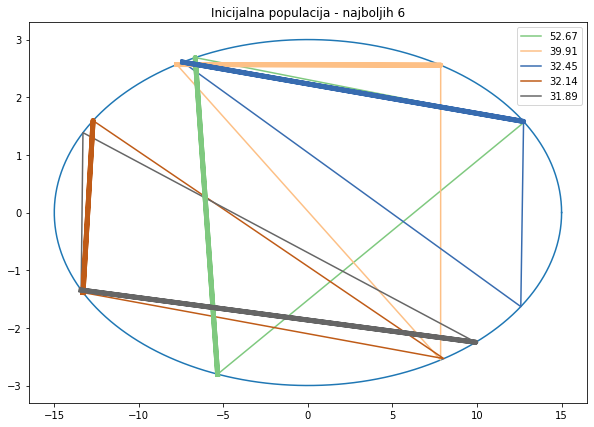

In [29]:
population = generate_initial_population(50, 32)
area, X, Y = evaluate_population(population, a, b)
plt.figure("init", figsize = (10, 7))
plt.title('Inicijalna populacija - najboljih 6')
plot_elipse("init", a, b)
plot_best_triangles("init", area, X, Y, 5)
plot_base("init", area, X, Y, 5)
_ = plt.legend(loc="best")